In [1]:
from tqdm import tqdm_notebook
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import umap
import os
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.cluster import DBSCAN, MeanShift, AgglomerativeClustering, OPTICS, SpectralClustering, KMeans
from sklearn.metrics import silhouette_score, \
                            davies_bouldin_score, \
                            pairwise_distances, \
                            confusion_matrix, \
                            f1_score, \
                            accuracy_score, \
                            make_scorer, \
                            calinski_harabasz_score, \
                            homogeneity_score, \
                            v_measure_score

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors, KernelDensity
from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap
# %matplotlib notebook
import matplotlib.pyplot as plt
from itertools import combinations
from collections import defaultdict
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from mpl_toolkits.mplot3d import Axes3D 
import multiprocessing
from joblib import Parallel, delayed
from utils import filter_paths, NPR, clustering
np.random.seed(42)
from lightgbm import LGBMClassifier


Bad key "text.kerning_factor" on line 4 in
/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
root_separate = './separate_datasets_proj/'
paths_separate = [os.path.join(root_separate,path) for path in os.listdir(root_separate)]
label2path_separate = {}
datasets_separate = {}
for path in paths_separate:
    label = path.split('/')[-1].split('.')[0]
    label2path_separate[label] = path
    datasets_separate[label] = np.genfromtxt(path, delimiter=';')

In [3]:
dataset_name = 'AGP'
taxonomic_level = 'o'
data = datasets_separate[f'{dataset_name}_proj_{taxonomic_level}']

In [4]:
# perc_list = []
# knn_range = np.arange(5, 100, 1)
# for n_neighbors in tqdm_notebook(knn_range):
#     nn = NearestNeighbors(n_neighbors=n_neighbors)
#     nn.fit(data)
#     neigborhood_X_dist, neigborhood_X_ind = nn.kneighbors(data, n_neighbors=n_neighbors)
#     mean_neigh_distances = neigborhood_X_dist[:,1:].mean(1)
# #     perc_list.append(np.percentile(mean_neigh_distances, 0.9))
#     perc_list.append(np.mean(mean_neigh_distances))    

In [5]:
# plt.figure()
# plt.plot(knn_range, perc_list)
# plt.show()

In [6]:
# construct the embedding, for the alternative choice of parameters refer to guide on UMAP, i.e. in report
# to recalculate the previous choices of parameters refer to the plots below

ump = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.2, spread = 1., metric='manhattan')
embedding = ump.fit_transform(data)
# results3d_separate = Parallel(n_jobs=-1)(delayed(apply_umap)(umap, data) for _, data in datasets_separate.items())  

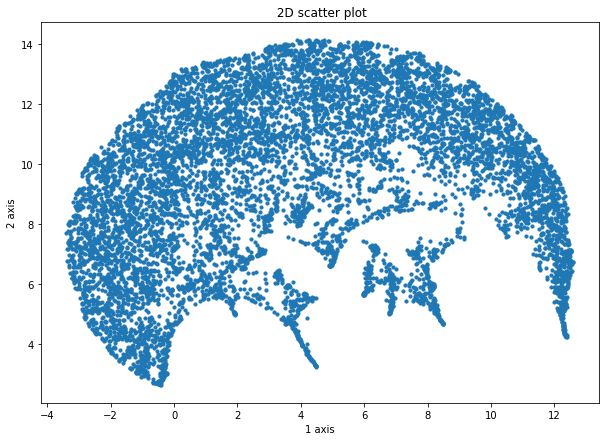

In [7]:
# parameters are: n_neighbors=15, n_components=2, min_dist=0.0, spread = 1.5, metric='euclidean'
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="rectilinear")
ax.scatter(embedding[:, 0], embedding[:, 1], s = 10)
plt.title(" 2D scatter plot")
ax.set_xlabel('1 axis')
ax.set_ylabel('2 axis')
plt.show()

<IPython.core.display.Javascript object>


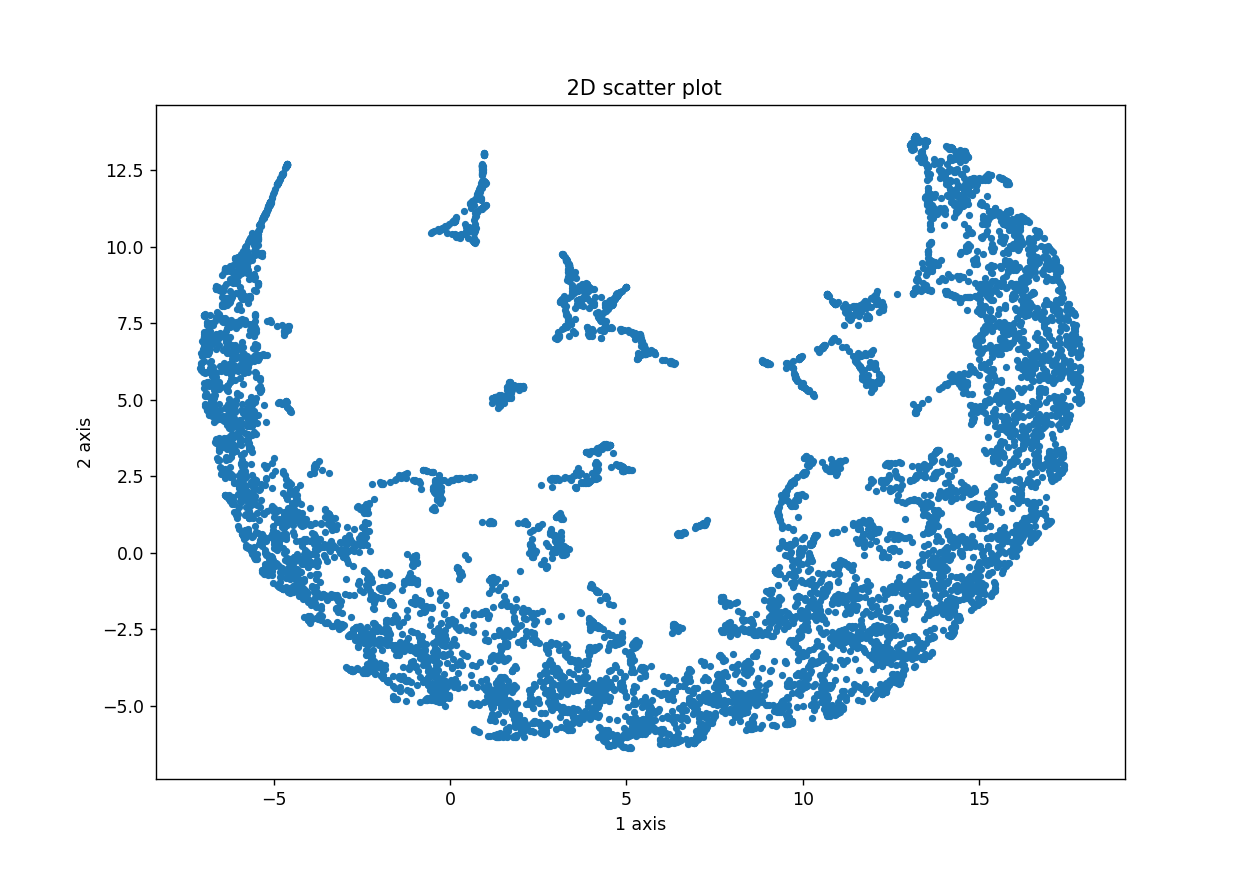

In [13]:
# parameters are: n_neighbors=15, n_components=2, min_dist=0.0, spread = 1.5, metric='euclidean'
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="rectilinear")
ax.scatter(embedding[:, 0], embedding[:, 1], s = 10)
plt.title(" 2D scatter plot")
ax.set_xlabel('1 axis')
ax.set_ylabel('2 axis')
plt.show()

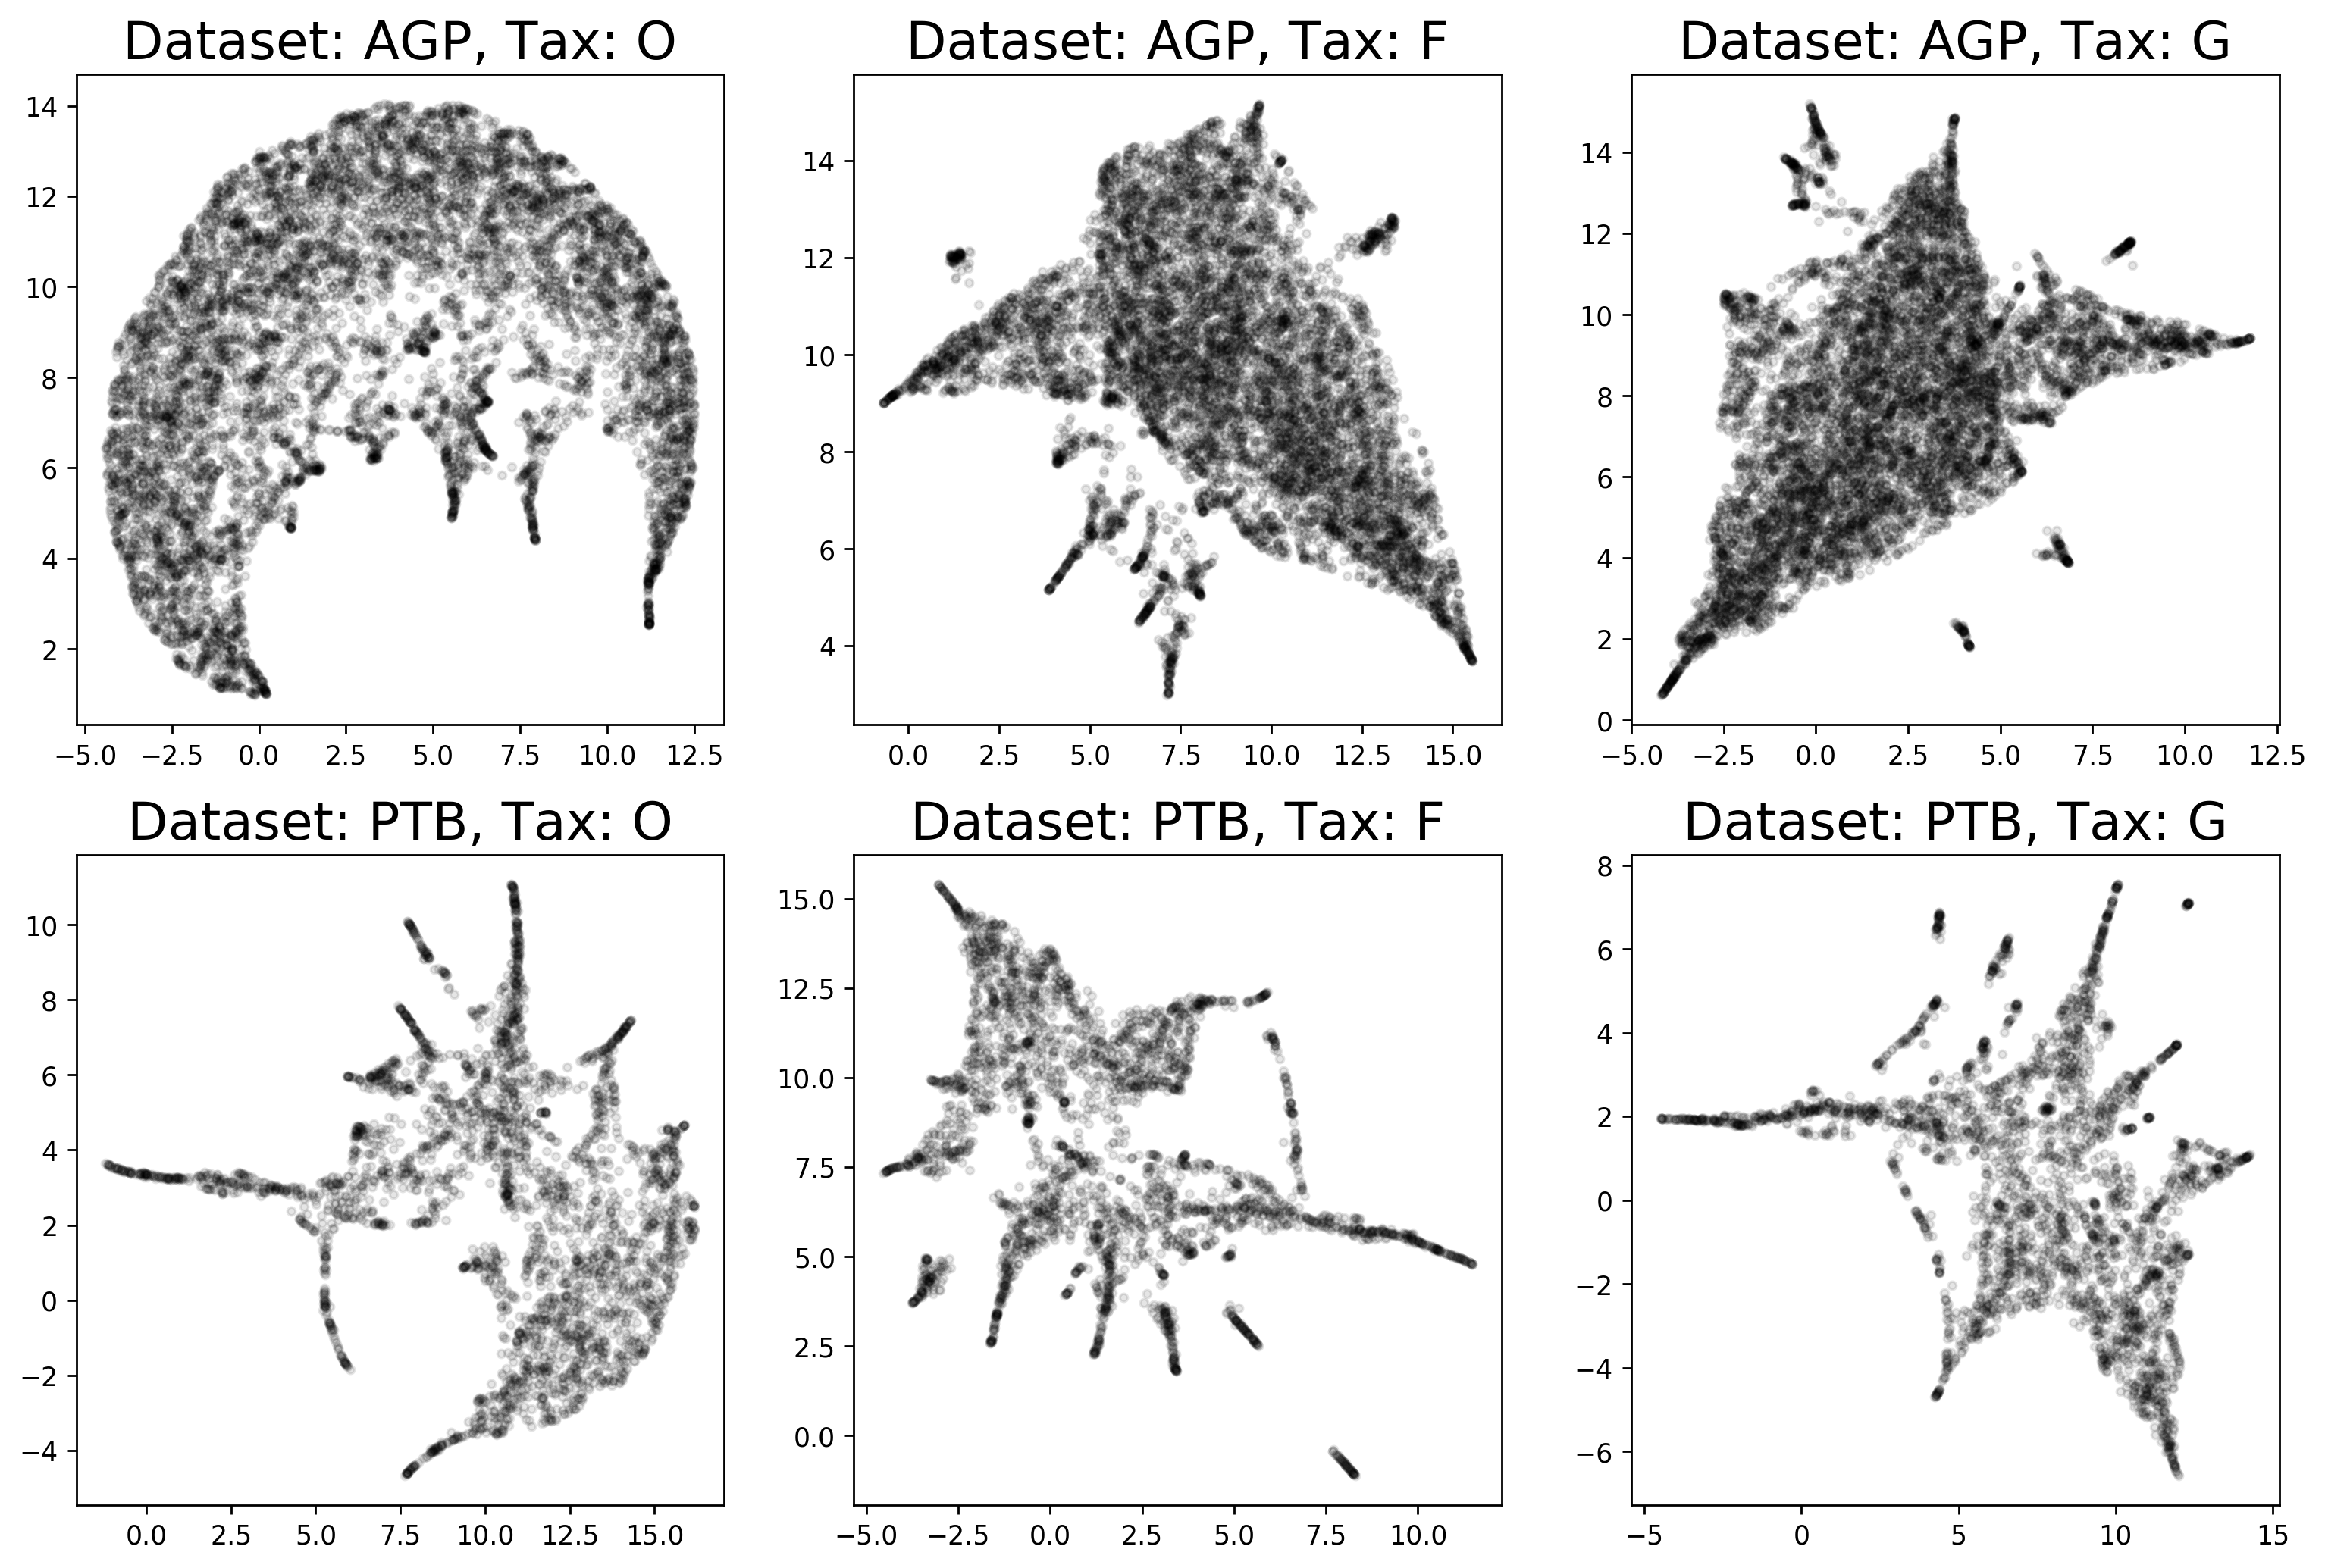

In [9]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15,10), dpi=250)
for i,dataset_name in enumerate(['AGP', 'ptb'], start=0):
    for j,tax_name in enumerate(['o', 'f', 'g'], start=0):
        label = '_'.join([dataset_name, 'proj', tax_name])
        data = datasets_separate[label]
        ump = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.2, spread = 1., metric='euclidean')
        v = ump.fit_transform(data)
        ax[i,j].scatter(v[:,0], v[:,1], marker='.', alpha=0.1, color='black')
        ax[i,j].set_title(f'Dataset: {dataset_name.upper()}, Tax: {tax_name.upper()}', fontsize=20)
plt.show()

# Analyze outliers groups

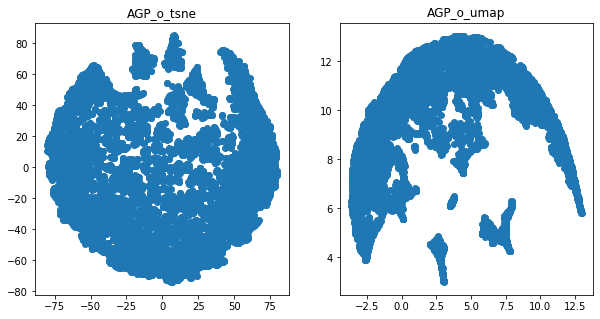

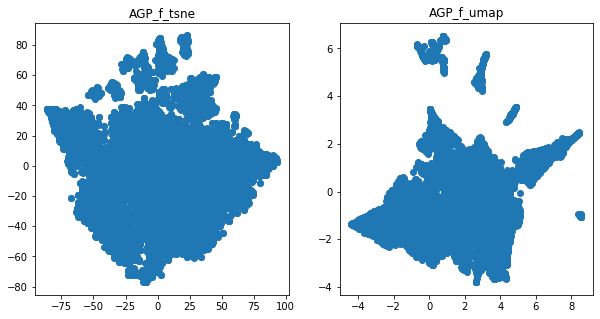

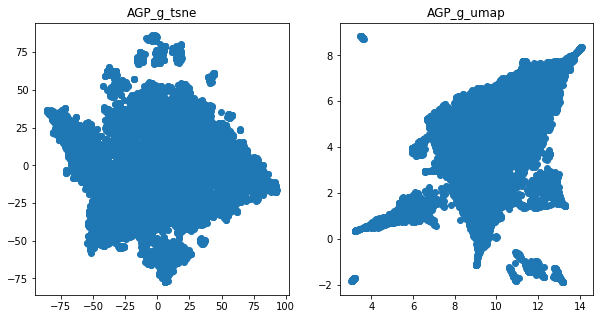

In [6]:
dataset = 'AGP'
embeddings = {}
n_neighbours = 30
methods ={'tsne':TSNE(n_components=2, perplexity=min(30,n_neighbours), metric='manhattan', random_state=42, init='pca', n_jobs=-1),
          'umap':umap.UMAP(n_neighbors=n_neighbours, n_components=2, min_dist=0.0, spread = 1., metric='manhattan', random_state=42)}

data_orig = {}

for tax_level in ['o', 'f', 'g']:

    data_out = datasets_separate[f'{dataset}_proj_{tax_level}']
    dataframe_out = pd.read_csv(f'{dataset}/pivot_{tax_level}_normalized.csv', skipinitialspace=True, sep=';', engine='python')
    dataframe_out = dataframe_out.drop('Unnamed: 0', axis = 1)#.values
    
    data_orig['_'.join([dataset, tax_level])] = dataframe_out
    
    fig,axes = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
    for i,(method_name, method) in enumerate(methods.items()):
        label = '_'.join([dataset, tax_level, method_name])
        embedding = method.fit_transform(data_out)
        embeddings[label] = embedding
        
        axes[i].scatter(embedding[:, 0], embedding[:, 1])
        axes[i].set_title(label)
plt.show()

In [37]:
clustering_results = defaultdict(dict)

clustering_name = 'DBSCAN' # 'DBSCAN' ,'KMeans', 'AgglomerativeClustering'

for label, embedding in tqdm_notebook(embeddings.items()):
    
    dataset_name, tax_level, method_name = label.split('_')
    data_out = datasets_separate[f'{dataset_name}_proj_{tax_level}']
    dataframe_out = pd.read_csv(f'{dataset_name}/pivot_{tax_level}_normalized.csv', skipinitialspace=True, sep=';', engine='python')
    dataframe_out = dataframe_out.drop('Unnamed: 0', axis = 1)#.values
    
    if clustering_name == 'DBSCAN':
        nn=NearestNeighbors(n_neighbors=10)
        nn.fit(embedding)
        embedding_kneighbours,_ = nn.kneighbors(embedding)
    #     m = embedding_kneighbours[:,1:].max()
        m = np.quantile(embedding_kneighbours[:,1:].flatten(), q=0.999)
        clustering_method = DBSCAN(eps=m)
    elif clustering_name == 'AgglomerativeClustering':
        clustering_method = AgglomerativeClustering(n_clusters=4)
    elif clustering_name == 'KMeans':
        clustering_method = KMeans(n_clusters=4)
    else:
        raise RuntimeError
    
    y = clustering_method.fit_predict(embedding)
    clustering_results[label]['y'] = y
    non_noise_mask = y!=-1
    n_clusters = len(np.unique(y[non_noise_mask]))
    
    print(f'n_clusters: {n_clusters} for {label}')

    npr = NPR(data_out[non_noise_mask], embedding[non_noise_mask], n_neighbours)
    
    if n_clusters > 1:
        sh_orig = silhouette_score(dataframe_out[non_noise_mask], y[non_noise_mask])
        db_orig = davies_bouldin_score(dataframe_out[non_noise_mask], y[non_noise_mask])
        sh_emb = silhouette_score(embedding[non_noise_mask], y[non_noise_mask])
        db_emb = davies_bouldin_score(embedding[non_noise_mask], y[non_noise_mask])

        sh_emb = "{:.2f}".format(sh_emb)
        db_emb = "{:.2f}".format(db_emb)
        sh_orig = "{:.2f}".format(sh_orig)
        db_orig = "{:.2f}".format(db_orig)

        clustering_results[label]['sh_emb'] = sh_emb
        clustering_results[label]['db_emb'] = db_emb
        clustering_results[label]['sh_orig'] = sh_orig
        clustering_results[label]['db_orig'] = db_orig

#     break
#     plt.figure()
#     plt.scatter(embedding[:, 0][y==-1], embedding[:, 1][y==-1], label=f'noise', color='grey')
#     for i in range(n_clusters):
#         p = round(sum(y==i)/len(y),2)
#         plt.scatter(embedding[:, 0][y==i], embedding[:, 1][y==i], label=f'cluster: {i}, p={p}')
        
#     plt.title(f'Number of clusters: {n_clusters}, NPR: {npr}, \n Silh: {sh_emb}, DB: {db_emb}, \n Silh Orig: {sh_orig}, DB Orig: {db_orig}')
#     plt.legend()
#     plt.show()

n_clusters: 4 for AGP_o_tsne
n_clusters: 5 for AGP_o_umap
n_clusters: 5 for AGP_f_tsne
n_clusters: 5 for AGP_f_umap
n_clusters: 7 for AGP_g_tsne
n_clusters: 6 for AGP_g_umap



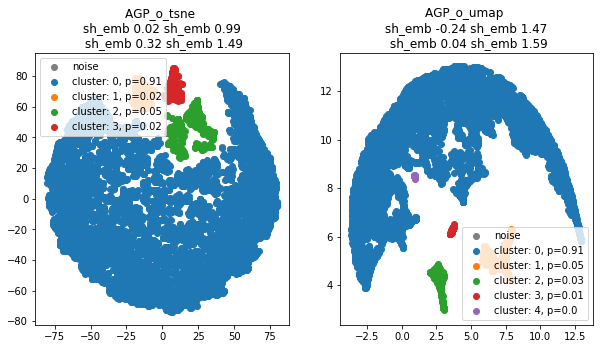

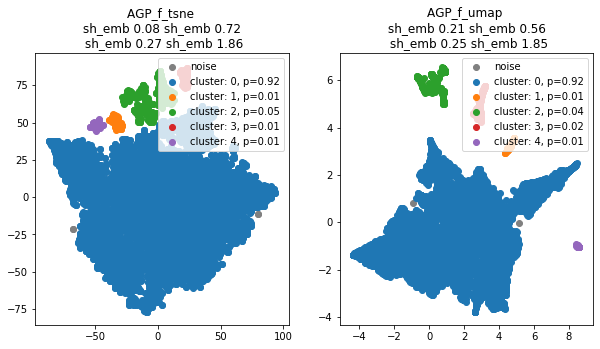

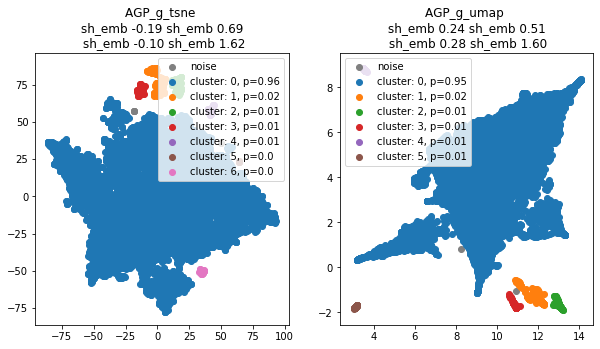

In [38]:
for tax_level in ['o', 'f', 'g']:
    fig,axes = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
    for i,(method_name) in enumerate(methods.keys()):
        label = '_'.join([dataset, tax_level, method_name])
        embedding =embeddings[label]
        y = clustering_results[label]['y']
        n_clusters = len(np.unique(y[y!=-1]))
        
        sh_emb, db_emb, sh_orig, db_orig = '','','',''
        if n_clusters > 1:
            sh_emb = clustering_results[label]['sh_emb']
            db_emb = clustering_results[label]['db_emb']
            sh_orig = clustering_results[label]['sh_orig']
            db_orig = clustering_results[label]['db_orig']
        
        axes[i].scatter(embedding[:, 0][y==-1], embedding[:, 1][y==-1], label=f'noise', color='grey')
        for k in range(n_clusters):
            p = round(sum(y==k)/len(y),2)
            axes[i].scatter(embedding[:, 0][y==k], embedding[:, 1][y==k], label=f'cluster: {k}, p={p}')
        axes[i].set_title(' '.join([label, '\n',\
                                    'sh_emb', sh_emb, \
                                    'sh_emb', db_emb, \
                                    '\n',\
                                    'sh_emb', sh_orig, \
                                    'sh_emb', db_orig]))
        axes[i].legend()
plt.show()

Higher dimensionality leads to more clusters shards and higher gap

In [39]:
def calc_intersection(y1,y2):
    y1_unique = np.unique(y1)
    y2_unique = np.unique(y2)
    sim = np.zeros((len(y1_unique),len(y2_unique)))
    for i in y1_unique:
        for j in y2_unique:
            sim[i,j] = ((y1==i)*(y2==j)).sum()/sum(y1==i)
    return sim

In [40]:
def v_measure_score_smallest(y1,y2):
    most_similar_mask = (y1 == 0)*(y2 == 0)
    return v_measure_score(y1[~most_similar_mask],
                           y2[~most_similar_mask])

In [41]:
y_s = []
labels = []
for k,v in clustering_results.items():
    y = v['y']
    y_s.append(y)
    labels.append(k)
y_s = np.stack(y_s)

In [42]:
Y = squareform(pdist(y_s, metric=v_measure_score_smallest))

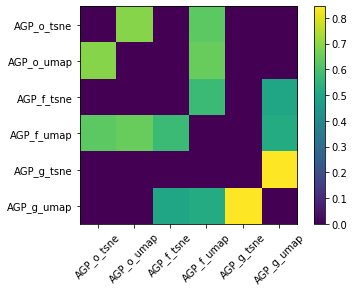

In [74]:
Y_thr = Y.copy()
Y_thr[Y_thr < 0.5] = 0.
plt.imshow(Y_thr)
plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45)
plt.yticks(ticks=np.arange(len(labels)), labels=labels, rotation=0)
plt.colorbar()
plt.show()

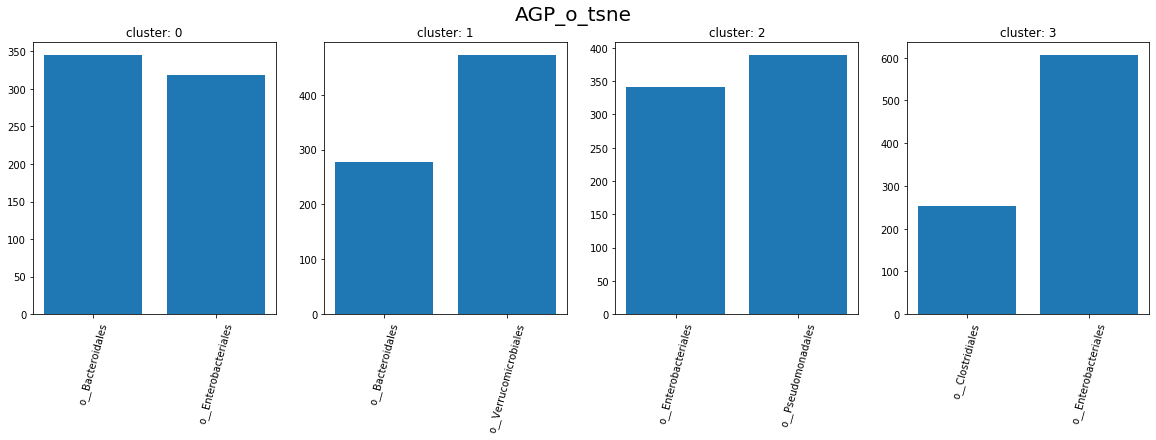

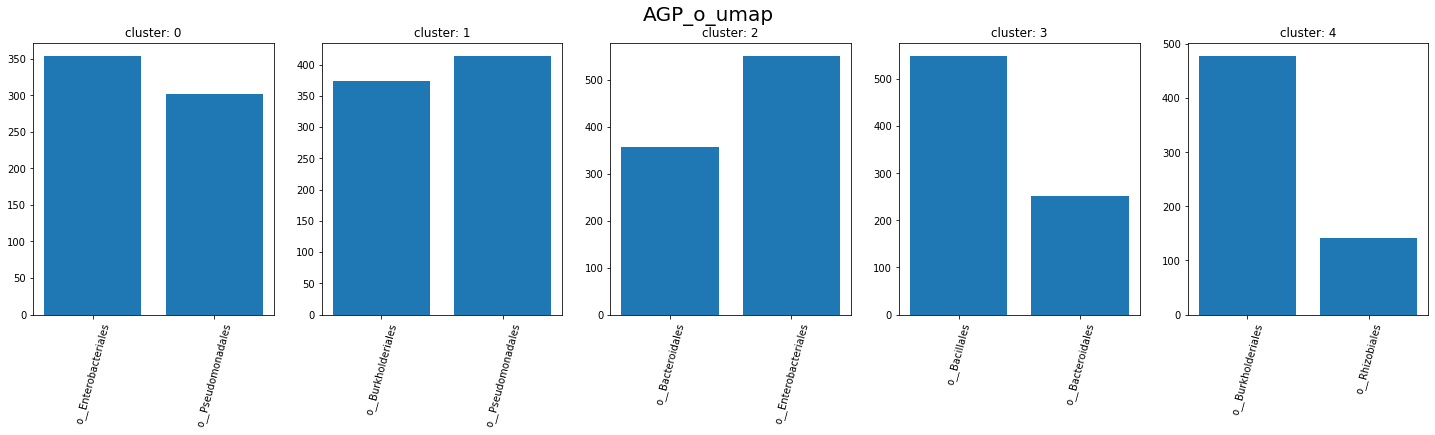

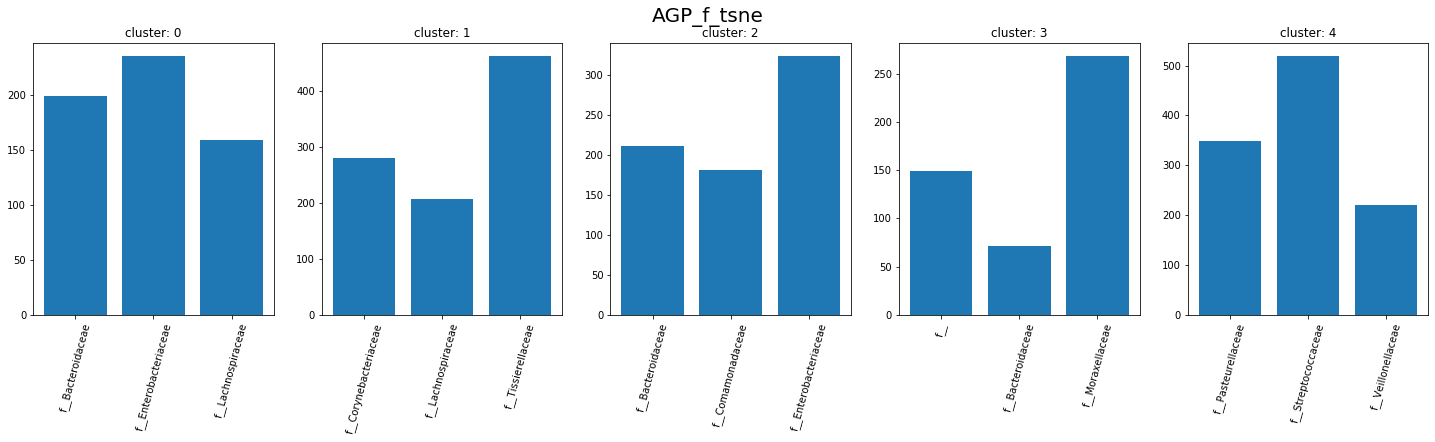

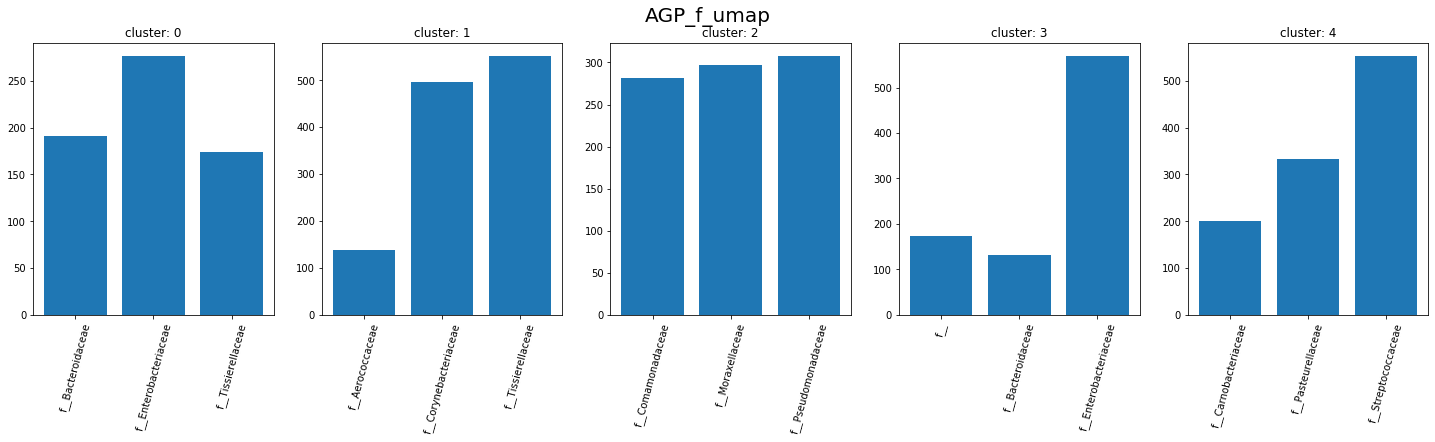

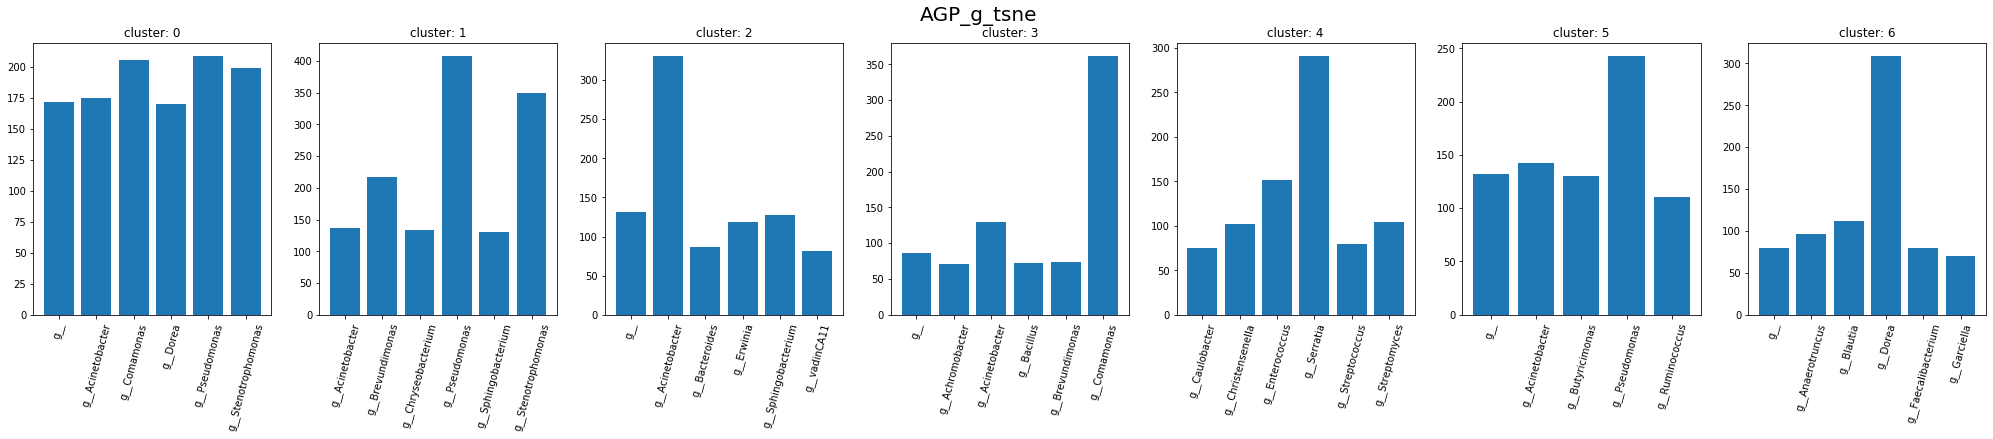

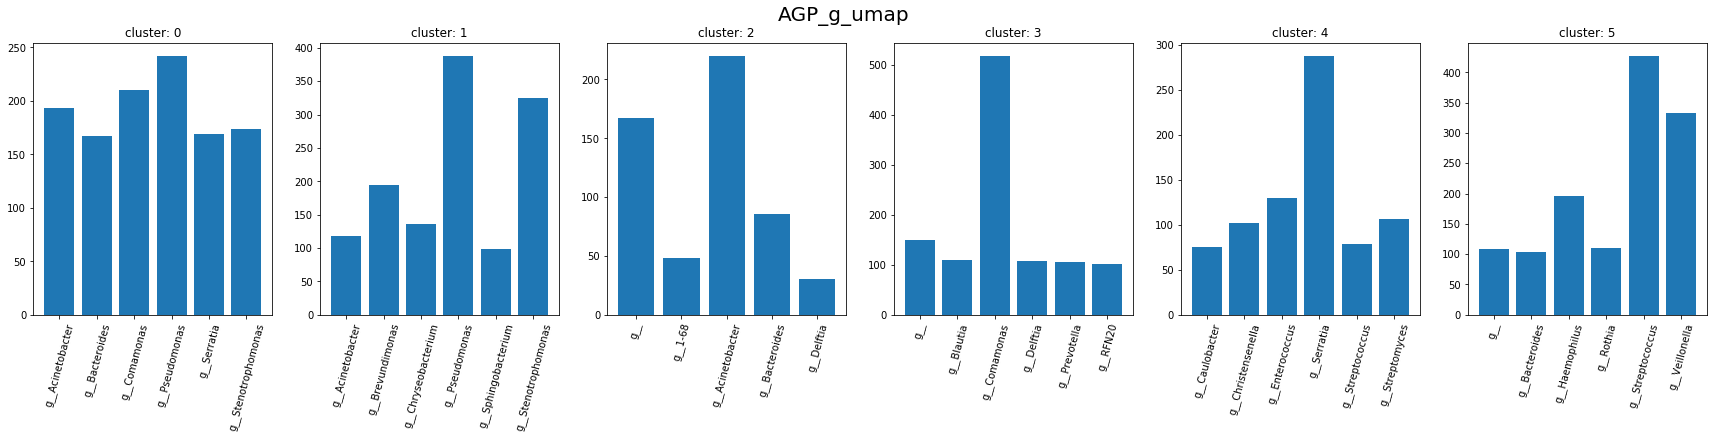

In [90]:
classification_results = defaultdict(dict)
for k,v in clustering_results.items():
    y = v['y']
    dataframe_orig = data_orig['_'.join(k.split('_')[:-1])]
    clusters = np.unique(y[y!=-1])
    fig, axes = plt.subplots(ncols=len(clusters), nrows=1, figsize=(len(clusters)*5,5))
    for i,cluster_number in enumerate(clusters):
        X_train = dataframe_orig.values
        features_names = dataframe_orig.columns
        y_train = np.zeros(len(X_train))
        y_train[y==cluster_number] = 1.
        est = LGBMClassifier(random_state=42)
        cross_val_score(est, X_train, y_train, scoring='f1').mean()
        est.fit(X_train, y_train)
        f_imp = est.feature_importances_
        imp_mask = f_imp > np.quantile(f_imp, q=0.99)
        axes[i].bar(x=features_names[imp_mask],
                height=f_imp[imp_mask])
        axes[i].set_xticklabels(labels = features_names[imp_mask], rotation=75)
        axes[i].set_title(f'cluster: {cluster_number}')
    fig.suptitle(k, fontsize=20)
plt.show()

    

# AGP, UMAP
## Tax O: 
### cluster 1: o__Burkholderiales	o__Pseudomonadales  
### cluster 2: o__Bacteroidales	o__Enterobacteriales
### cluster 3:  o__Bacillales

# ptb, UMAP
## Tax O: 
### cluster 1: o__Bacteroidales	o__Enterobacteriales	o__Lactobacillales	o__Pseudomonadales
### cluster 2: o__Bacteroidales	o__Enterobacteriales
### cluster 3: o__Actinomycetales	o__Bacillales  
### cluster 4: o__Rhizobiales

# AGP, TSNE
## Tax O: 
### cluster 1: 
### cluster 2: 
### cluster 3:  

# ptb, TSNE
## Tax O: 
### cluster 1: 
### cluster 2: 
### cluster 3: 
### cluster 4: 


# How big is the gap?